In [197]:
import matplotlib.pyplot as plt
import pylab
import pandas as pd
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

In [2]:
os.chdir("..")
from syllables_splitting import split

In [3]:
df = pd.read_csv("data/train.csv")

In [9]:
for i in range(6):
    df[f"syllable{i}"] = df["word"].apply(lambda x: split(x)[i] if len(split(x)) > i else "")

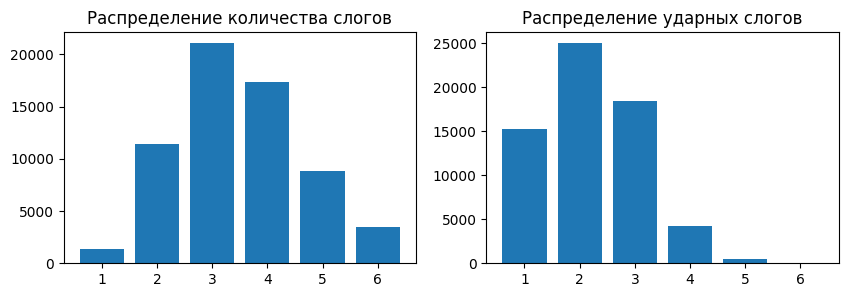

In [38]:
plt.figure(figsize=(10, 3))
pylab.subplot(1, 2, 1)
plt.bar(range(1, 7), [df["num_syllables"].value_counts()[i] for i in range(1, 7)])
plt.title("Распределение количества слогов")
pylab.subplot(1, 2, 2)
plt.bar(range(1, 7), [df["stress"].value_counts()[i] for i in range(1, 7)], label="Распределение ударных слогов")
plt.title("Распределение ударных слогов")
plt.show()

In [162]:
syllables = dict()
for i in range(6):
    for n in df[f"syllable{i}"]:
        if n == "":
            continue
        if n not in syllables.keys():
            syllables[n] = [0, 0, 0, 0, 0, 0]
        syllables[n][i] += 1

In [163]:
keys = list(syllables.keys())
values = [np.array(i) / sum(i) for i in syllables.values()]

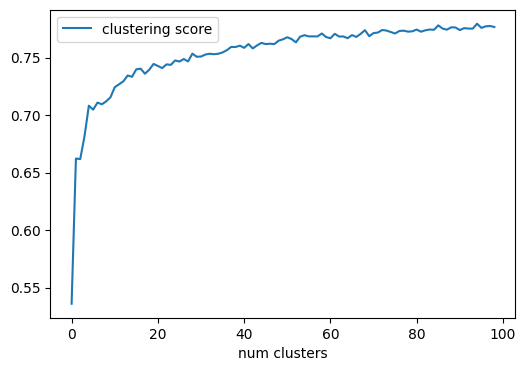

In [149]:
metrics = []
for k in range(2, 101):
    model = KMeans(n_clusters=k).fit(values)
    metrics.append(silhouette_score(values, model.labels_))
plt.figure(figsize=(6, 4))
plt.plot(metrics, label="clustering score")
plt.legend()
plt.xlabel("num clusters")
plt.show()

In [143]:
new_values = TSNE(n_components=2, learning_rate="auto", init="random").fit_transform(np.array(values))

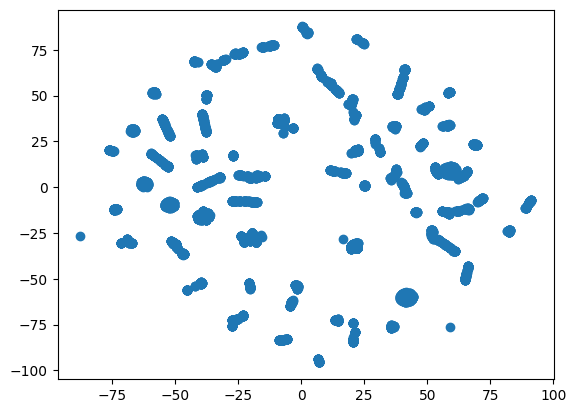

In [118]:
plt.scatter(values[:, 0], values[:, 1])
plt.show()

### Токены хорошо кластеризуются, выделилось в районе 50 мини кластерчиков. Вот например кластерчик токенов, которые почти всегда стоят на 1 месте (приставки и первые слоги корней):

In [148]:
for i in np.where((new_values[:, 0] > 5) & (new_values[:, 0] < 30) & (new_values[:, 1] < -10) & (new_values[:, 1] > -50))[0][:10]:
    print(keys[i], values[i])

у [0.86618827 0.0953989  0.03165893 0.0067539  0.         0.        ]
куль [0.85185185 0.07407407 0.07407407 0.         0.         0.        ]
мэ [0.875 0.125 0.    0.    0.    0.   ]
э [0.88146912 0.07679466 0.03672788 0.00500835 0.         0.        ]
при [0.94662162 0.03040541 0.01891892 0.00405405 0.         0.        ]
о [0.82961623 0.08820575 0.06590315 0.01527024 0.00100462 0.        ]
жир [0.60869565 0.04347826 0.34782609 0.         0.         0.        ]
хро [0.82758621 0.17241379 0.         0.         0.         0.        ]
пре [0.84794673 0.13096559 0.01775805 0.00332963 0.         0.        ]
эр [0.83333333 0.08333333 0.08333333 0.         0.         0.        ]


### Попробуем оценить энтропию ударений для каждого из кластеров

In [164]:
model = KMeans(n_clusters=50).fit(values)

In [165]:
stress_counts = {}
for word, stress in zip(df["word"], df["stress"]):
    for i, syllable in enumerate(split(word)):
        if syllable not in stress_counts.keys():
            stress_counts[syllable] = [0, 0]
        if i == stress:
            stress_counts[syllable][0] += 1
        else:
            stress_counts[syllable][1] += 1

In [167]:
clusters_counts = {}
for i in range(50):
    clusters_counts[i] = [0, 0]
    for j in np.where(model.labels_ == i)[0]:
        clusters_counts[i][0] += stress_counts[keys[j]][0]
        clusters_counts[i][1] += stress_counts[keys[j]][1]

In [183]:
from math import log2

entropy = lambda x, y: -(x * log2(x) + y * log2(y))
metrics = []
for i in clusters_counts.values():
    s = i[0] + i[1]
    metrics.append(entropy(i[0] / s, i[1] / s))

In [181]:
sorted(["%.2f" % i for i in metrics])

['0.01',
 '0.12',
 '0.23',
 '0.30',
 '0.37',
 '0.39',
 '0.41',
 '0.47',
 '0.48',
 '0.51',
 '0.57',
 '0.58',
 '0.60',
 '0.61',
 '0.66',
 '0.67',
 '0.67',
 '0.70',
 '0.72',
 '0.74',
 '0.80',
 '0.81',
 '0.82',
 '0.83',
 '0.85',
 '0.89',
 '0.90',
 '0.92',
 '0.93',
 '0.93',
 '0.93',
 '0.94',
 '0.94',
 '0.94',
 '0.94',
 '0.94',
 '0.96',
 '0.96',
 '0.97',
 '0.97',
 '0.97',
 '0.98',
 '0.98',
 '0.98',
 '0.98',
 '0.99',
 '1.00',
 '1.00',
 '1.00',
 '1.00']

### Для некоторых кластеров энтропия почти нулевая за счет того, что слоги в них никогда не бывают ударными, в некоторых энтропия маленькая за счет того, что слоги в них чаще являются ударными (такая зависимость встречается реже, скорее всего это тупо кластеры, куда отлетели слоги с буквой Ё). В целом средняя энтропия всех кластеров ~ 0.75, если векторизовать слова через методы, не учитывающие порядок слов (tf-idf, count vectorizer...) получится скорее всего что-то не сильно обгоняющее бейзлайн